In [1]:
#Importieren der notwendigen librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Laden des Datensatzes von einer csv-Datei in ein pandas DataFrame
dataset_EDDM = pd.read_pickle('C:/Users/Danie/Desktop/Arbeit (sonstiges)/Übung_AirportOperations/AO Übung 2/Dataset_EDDM.pkl')

**Aufgabe 1) Slot adherence**

Text(0, 0.5, 'standard deviation [min]')

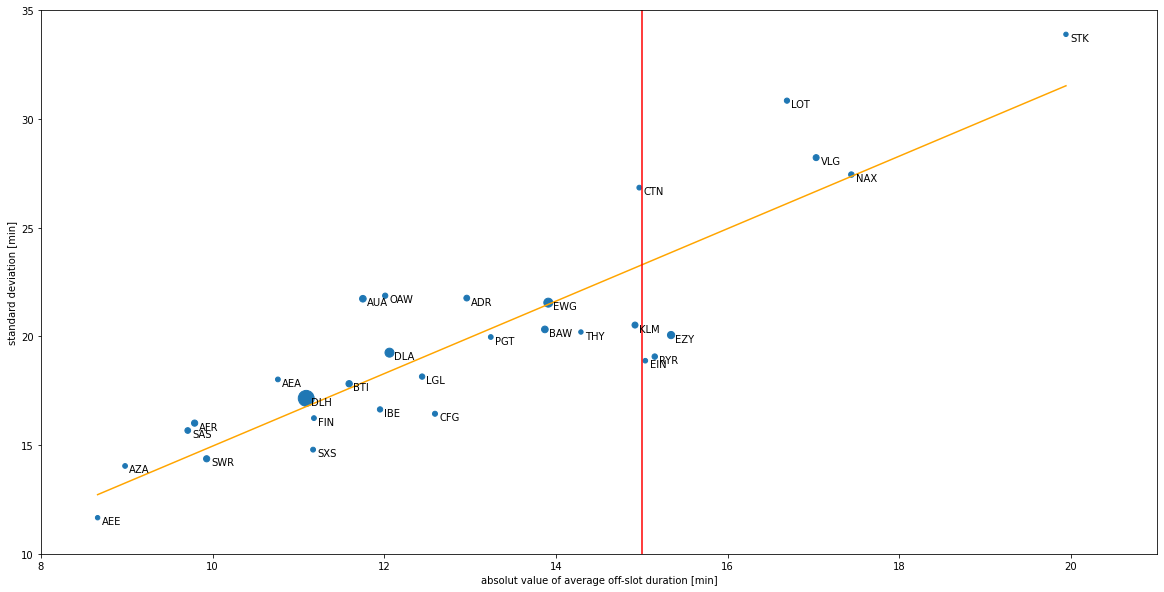

In [13]:
#Dataset mit allen Landungen
arr = dataset_EDDM.query('Destination=="EDDM"')

#Abweichung zwischen ATA und STA
arr['delta_slot'] = arr['ATA'] - arr['STA']
arr['delta_slot'] = arr['delta_slot'].dt.total_seconds().astype(int)

#Ermitteln der relevanten Flugzeugmuster
airlines = arr.groupby('Airline').count()
airlines = airlines.sort_values(by='Departure', ascending=False)
airlines = airlines.query('Departure>=30')
airlines = airlines.index.values.tolist()

#DataFrame für Ergebnisse definieren
airline_data = pd.DataFrame([])

#Schleife für jede airline erzeugen
for i in airlines:
    #Filtern der Daten nach airline
    data = arr.query('Airline==@i')
    
    #Werte der Landezeitabweichung ermitteln
    std = data['delta_slot'].std()
    
    #Abspeichern der Standardabweichung in Ergebnis DataFrame
    airline_data.loc[i,'std'] = round(std/60,2)
    
    #absolute Abweichung zwischen tatsächlicher und Ziellandezeit
    data['abs_delta_slot'] = abs(data['delta_slot'])
    
    #Berechnen des durchschnittlichen Wertes
    absmu = data['abs_delta_slot'].mean()
    
    #Abspeichern des durchschnittlichen Wertes im Ergebnis DataFrame
    airline_data.loc[i,'absmu'] = round(absmu / 60,2)
    
    #Bestimmen der Anzahl der Flüge einer Airline und abspeicehrn im Ergebnis DataFrame
    airline_data.loc[i,'size'] = round(np.sqrt(len(data))*3,2)

#Absteigendes sortieren der Airlines nach absoluten Wert der mittleren Slotabweichung
airline_data = airline_data.sort_values(by='absmu', ascending=False)

#Ermitteln der Airlines, welche Toleranzfenster im Durchschnitt nicht einhalten und Sortierung nach der Standardabweichung
crit_airlines = airline_data.query('absmu>15').sort_values(by='std', ascending=True)

#Extrahieren der Daten für das Diagramm
y = airline_data['std'].values.tolist()
x = airline_data['absmu'].values.tolist()
size = airline_data['size'].values.tolist()
labels = airline_data.index.values.tolist()

#Erstellen eines Plots
fig,ax = plt.subplots(1,1,figsize=(20,10))

#Erstellen eines Scatterplots
ax.scatter(x,y,s=size)

#Beschriftung für jeden Datenpunkt
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i]+0.05, y[i]-0.3),clip_on=True)

#Erstellen der Daten zur Ermittlung der Regressionsgeraden    
reg_data = airline_data.iloc[1:,:]
x_reg = reg_data['absmu'].values.tolist()
y_reg = reg_data['std'].values.tolist()

#Bestimmen der Regressionsgeradenparameter
coef = np.polyfit(x_reg, y_reg, 1)
poly1d_fn = np.poly1d(coef) 

#Plotten der regressionsgeraden
plt.plot(x_reg, poly1d_fn(x_reg), color='orange')

#Plotten der Toleranzgrenze 
ax.plot([15,15],[0,100], color='red')

#Ausprägung der x- und y-Achse festlegen
#ax.set_xlim(8,25)
#ax.set_ylim(9,60)
ax.set_xlim(8,21)
ax.set_ylim(10,35)

#Achsenbeschriftung definieren
ax.set_xlabel('absolut value of average off-slot duration [min]')
ax.set_ylabel('standard deviation [min]')

**Aufgabe 2) Kapazitätsdiagramm**

In [4]:
#Start- und Endzeitpunkt zur Bestimmung  
start_hour = pd.Timestamp(2019,9,1,0,0,0)
end_hour = pd.Timestamp(2019,9,30,23,0,0)

#Liste mit allen Stunden zwischen Start- und Endzeitpunkt
hour_list = pd.date_range(start_hour, end_hour, freq='1h')

#DataFrame für das Ergebnis definieren
MOV_hour_results = pd.DataFrame([])

#Schleife zur Ermitlung der Movements für jede Stunde initiieren
for i in hour_list:
    #Mithilfe unterer Grenze (i) die obere Grenze (j) bestimmen --> Zeitdauer = 1 Stunde
    j = i + pd.Timedelta(1, unit='h')
    
    #Filtern des Gesamtdatensatzes nach Ankünften am Flughafen EDDM
    arr = dataset_EDDM.query('Destination=="EDDM"')
    #Suche nach Flügen deren ATA innerhalb der Grenzen von i und j liegen
    arr = arr.query('ATA>=@i and ATA<=@j')
    #Bestimmen der Anzahl aller Flüge, welche oberes Kriterium erfüllen
    arr = len(arr)
    
    #Filtern des Gesamtdatensatzes nach Abflügen am Flughafen EDDM
    dep = dataset_EDDM.query('Departure=="EDDM"')
    #Suche nach Flügen deren ATD innerhalb der Grenzen von i und j liegen
    dep = dep.query('ATD>=@i and ATD<=@j')
    #Bestimmen der Anzahl aller Flüge, welche oberes Kriterium erfüllen
    dep = len(dep)
    
    #Speichen der Ergebnisse im Lösungs DataFrame
    MOV_hour_results.loc[i,'Arr'] = arr
    MOV_hour_results.loc[i,'Dep'] = dep    

#Bestimmen der Movements durch Addition der Anzahlen für Starts und Landungen für jede Stunde    
MOV_hour_results['Mov'] = MOV_hour_results['Arr'] + MOV_hour_results['Dep']  

Text(0, 0.5, 'Arrivals')

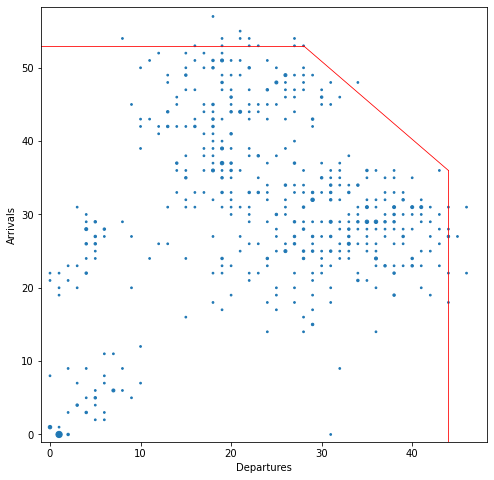

In [11]:
#Gruppieren und Ermittlung der Anzahl der bubbles
bubble = MOV_hour_results.groupby(['Arr','Dep']).count()
bubble = bubble.iloc[1:,:]

#Definieren der Achsen und Diagrammwerte
x = bubble.index.get_level_values('Arr').tolist()
y = bubble.index.get_level_values('Dep').tolist()
z = bubble['Mov'].values.tolist()
z = [i * 3 for i in z]

#Erstellen eines Plots
fig, ax = plt.subplots(1,1,figsize=(8,8))

#Scatterplot erstellen
ax.scatter(x, y, s=z)

#Kapazitätsgrenzen einzeichnen
ax.plot([-2,28],[53,53],color='red', linewidth=0.8)
ax.plot([28,44],[53,36],color='red', linewidth=0.8)
ax.plot([44,44],[36,-2],color='red', linewidth=0.8)

#Ausprägung der x- und y-Achse festlegen
ax.set_xlim(-1,48.3)
ax.set_ylim(-1,58.3)

#Achsenbeschriftung definieren
ax.set_xlabel('Departures')
ax.set_ylabel('Arrivals')

In [6]:
#Start- und Endzeitpunkt zur Bestimmung  
start_hour = pd.Timestamp(2019,9,1,0,0,0)
end_hour = pd.Timestamp(2019,9,30,23,0,0)

#Liste mit allen Stunden zwischen Start- und Endzeitpunkt
hour_list = pd.date_range(start_hour, end_hour, freq='1h')

#DataFrame für das Ergebnis definieren
MOV_10m_results = pd.DataFrame([])

#Schleife zur Ermitlung der Movements für jede Stunde initiieren
for i in hour_list:
    #Mithilfe unterer Grenze (i) die obere Grenze (j) bestimmen --> Zeitdauer = 1 Stunde
    j = i + pd.Timedelta(10, unit='min')
    
    #Filtern des Gesamtdatensatzes nach Ankünften am Flughafen EDDM
    arr = dataset_EDDM.query('Destination=="EDDM"')
    #Suche nach Flügen deren ATA innerhalb der Grenzen von i und j liegen
    arr = arr.query('ATA>=@i and ATA<=@j')
    #Bestimmen der Anzahl aller Flüge, welche oberes Kriterium erfüllen
    arr = len(arr)
    
    #Filtern des Gesamtdatensatzes nach Abflügen am Flughafen EDDM
    dep = dataset_EDDM.query('Departure=="EDDM"')
    #Suche nach Flügen deren ATD innerhalb der Grenzen von i und j liegen
    dep = dep.query('ATD>=@i and ATD<=@j')
    #Bestimmen der Anzahl aller Flüge, welche oberes Kriterium erfüllen
    dep = len(dep)
    
    #Speichen der Ergebnisse im Lösungs DataFrame
    MOV_10m_results.loc[i,'Arr'] = arr
    MOV_10m_results.loc[i,'Dep'] = dep    

#Bestimmen der Movements durch Addition der Anzahlen für Starts und Landungen für jede Stunde    
MOV_10m_results['Mov'] = MOV_10m_results['Arr'] + MOV_10m_results['Dep']  

Text(0, 0.5, 'Arrivals')

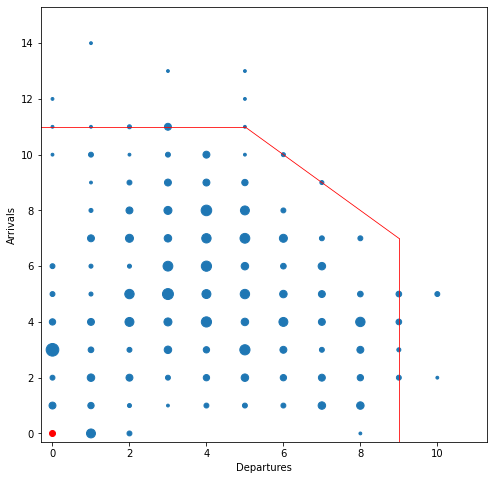

In [15]:
#Gruppieren und Ermittlung der Anzahl der bubbles
bubble = MOV_10m_results.groupby(['Arr','Dep']).count()
bubble = bubble.iloc[1:,:]

#Definieren der Achsen und Diagrammwerte
starts = bubble.index.get_level_values('Arr').tolist()
lands = bubble.index.get_level_values('Dep').tolist()
z = bubble['Mov'].values.tolist()
z = [i * 8 for i in z]

#Erstellen eines Plots
fig, ax = plt.subplots(1,1,figsize=(8,8))

#Scatterplot erstellen
ax.scatter(starts, lands, s=z)

#Dummy Scatter für Dep=0 and Arr=0
ax.scatter(0,0, color='red')

#Kapazitätsgrenzen einzeichnen
ax.plot([-2,5],[11,11],color='red', linewidth=0.8)
ax.plot([5,9],[11,7],color='red', linewidth=0.8)
ax.plot([9,9],[7,-2],color='red', linewidth=0.8)

#Ausprägung der x- und y-Achse festlegen
ax.set_xlim(-0.3,11.3)
ax.set_ylim(-0.3,15.3)

#Achsenbeschriftung definieren
ax.set_xlabel('Departures')
ax.set_ylabel('Arrivals')

**Aufgabe 3) Boxplot**

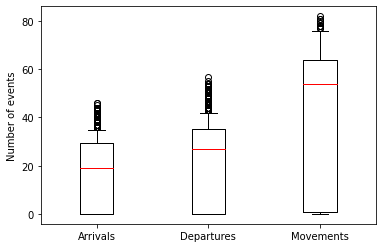

In [8]:
#Erstellen der Datensets für Starts, Landungen und Movements
arr = MOV_hour_results['Arr'].values.tolist()
dep = MOV_hour_results['Dep'].values.tolist()
mov = MOV_hour_results['Mov'].values.tolist()

#Verbinden der Datensätze zu einem Gesamtdatensatz
data = [arr, dep, mov]

#Definition der Eigenschaften für den Median
medianprops = dict(color='red')

#Erstellen eines Plots
fig, ax = plt.subplots(1,1)

#Erstellen eines Boxplots
ax.boxplot(data, medianprops=medianprops, whis=0.2);

#Achsenbeschritung
ax.set_ylabel('Number of events')
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Arrivals', 'Departures', 'Movements']);